In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [51]:
#Loading in data from MNIST dataset
df_train = pd.read_csv('./sample_data/mnist_train_small.csv')
df_test = pd.read_csv('./sample_data/mnist_test.csv')

In [52]:
df_train.head() #One row of this dataset is a digit 

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
idx = 6 
row = df_test.iloc[idx]
img = row[1:].values.reshape(28,28)

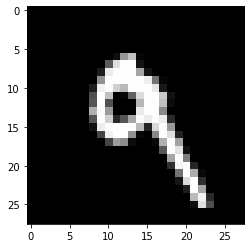

In [54]:
plt.imshow(img, cmap='gray') #A label for the 6th row of the dataframe 

In [55]:
#Must implement this class and 3 methods in order to initialize, get length and get item from the digits dataset
class DigitsDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        
        x = np.float32(row[1:].values) / 255.0
        y = row[0]
        
        return x,y

In [56]:
#Using the DigitsDataset class for the training and testing dataset
dataset_train = DigitsDataset(df_train)
dataset_test = DigitsDataset(df_test)

In [57]:
#Using the dataloader, it grabs a batch of data, in this case the batch size is 64
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 64, shuffle = True)

In [58]:
#Gets one batch of data
X_batch, Y_batch = next(iter(dataloader_train))

tensor(4)


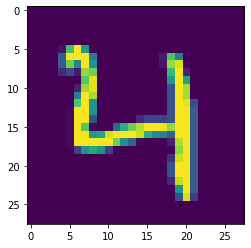

In [59]:
#Reshaping the data into 28,28 
plt.imshow(np.reshape(X_batch[0],(28,28)))

#Image of the first row in the test labels 
print(Y_batch[0])

In [60]:
#A class to specify the Neural Network architecture 
class SimpleNeuralNetwork(torch.nn.Module):
    #Initializing the neural network 
    def __init__(self):
        super().__init__() 
        
        #Layers in our network 
        self.dense1 = torch.nn.Linear(784,100) 
        self.dense2 = torch.nn.Linear(100,10)
        
        self.ReLU = torch.nn.ReLU()
        
    #Function that applies the neural network to a vector x   
    def forward(self,x):
        y = self.ReLU(self.dense1(x))
        z = self.dense2(y)
        
        return z

In [61]:
model = SimpleNeuralNetwork() #The Neural Network 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) #Directing our model to our device

In [71]:
loss_fun = torch.nn.CrossEntropyLoss() #Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #Similar to Stochastic Gradient Descent 

In [78]:
#Training the Neural Network
num_epochs = 35
N_train = len(dataset_train)
N_test = len(dataset_test)

train_losses = [] #Collect training losses
test_losses = [] #Collect testing losses 

#For the number of epochs 
for ep in range(num_epochs):
    
    model.train() #Puts model in training mode
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch, y_batch in dataloader_train: #Go through training data one batch at a time 
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_onebatch = loss_fun(outputs,y_batch)
        
        model.zero_grad()
        loss_onebatch.backward() #PyTorch computes gradient 
        optimizer.step() #One iteration of stochastic gradient descent / Adam 
        
        train_loss += loss_onebatch * N_batch
        
    model.eval() #Puts model in testing mode 
    test_loss = 0.0
    
    for X_batch, y_batch in dataloader_test:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.no_grad(): #Tells pyTorch that it does not need to keep track of gradient info
            N_batch = X_batch.shape[0]
            outputs = model(X_batch)
            loss_onebatch = loss_fun(outputs,y_batch)
            test_loss += loss_onebatch * N_batch
            
    train_losses.append(train_loss/N_train)
    test_losses.append(test_loss/N_train)
    
    print('Epoch : ', ep , '| Train Loss : ', train_loss/N_train, '| Test Loss : ', test_loss/N_train)
        

Epoch :  0 | Train Loss :  tensor(0.0210, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.3753)
Epoch :  1 | Train Loss :  tensor(0.0364, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4076)
Epoch :  2 | Train Loss :  tensor(0.0270, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4030)
Epoch :  3 | Train Loss :  tensor(0.0335, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.3868)
Epoch :  4 | Train Loss :  tensor(0.0390, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4763)
Epoch :  5 | Train Loss :  tensor(0.0612, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4085)
Epoch :  6 | Train Loss :  tensor(0.0437, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4023)
Epoch :  7 | Train Loss :  tensor(0.0474, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4242)
Epoch :  8 | Train Loss :  tensor(0.0274, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4123)
Epoch :  9 | Train Loss :  tensor(0.0345, grad_fn=<DivBackward0>) | Test Loss :  tensor(0.4343)
Epoch :  10 | Train Loss :  tensor(0.076

Text(0.5, 1.0, 'Objective Function vs Epoch')

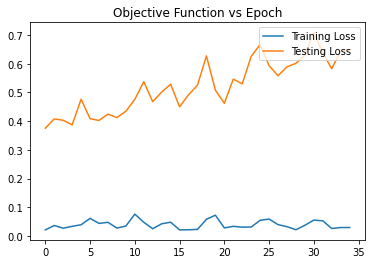

In [79]:
#A plot of the Objective Function against the Epochs 
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Testing Loss')
plt.legend(loc='upper right')
plt.title('Objective Function vs Epoch')

In [80]:
#Calculates the number of correct predictions and gives us the accuracy 
num_correct = 0 
model.eval()

for X_batch, y_batch in dataloader_test: 
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    with torch.no_grad():
        outputs = model(X_batch)
        num_correct += sum(np.argmax(outputs,axis=1) == y_batch)
        
print('Accuracy : ', num_correct/N_test)

Accuracy :  tensor(0.9669)


Using a learning rate of 0.001 and Epoch 15 : 97% accuracy 

Using a learning rate of 0.001 and Epoch 25 : 97% accuracy 

Using a learning rate of 0.001 and Epoch 35 : 97% accuracy 

Reducing the epochs will decrease the accuracy. 

Increasing the learning rate will decrease the accuracy. 